In [1]:
from typing import Union
import random
import os
import glob
import time
import gc

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from PIL import Image
import cv2
import geojson
from patchify import patchify

import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm



OPENSLIDE_PATH  = r"C:/openslide/openslide-win64/bin"

import os
if hasattr(os, "add_dll_directory"):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [2]:
DATA_PATH = "/mnt/d/UCL-HDS-DissertationDataset/BRACS/BRACS_WSI"
ANNOT_PATH = "/mnt/d/UCL-HDS-DissertationDataset/BRACS_WSI_Annotations"
PATCH_PATH = "./data/patches"

Fix random seeds

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Set device according to CUDA availablility

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
train_sample_patches_paths = glob.glob(PATCH_PATH + "/train_sample/*")

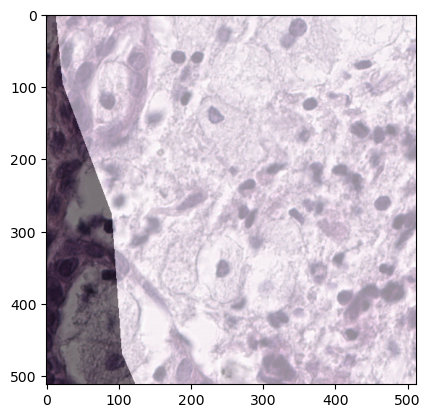

In [30]:
test_img_path = ""
test_mask_path = ""
for roi in glob.glob(train_sample_patches_paths[0] + "**/**"):
    img_paths = glob.glob(roi + "/patch/*.png")
    mask_paths = glob.glob(roi + "/mask/*.png")
    test_img_path = img_paths[0]
    test_mask_path = mask_paths[0]
    img = cv2.imread(img_paths[0], cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_paths[0], cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGRA2RGB)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.show()
        

    break

RGB image shape: (512, 512, 3)
RGB example pixel values: [148 116 149]
CIELAB image shape: (512, 512, 3)
CIELAB example pixel values:[135 147 115]
Black and white image shape: (512, 512)
Black and white example pixel values: 129


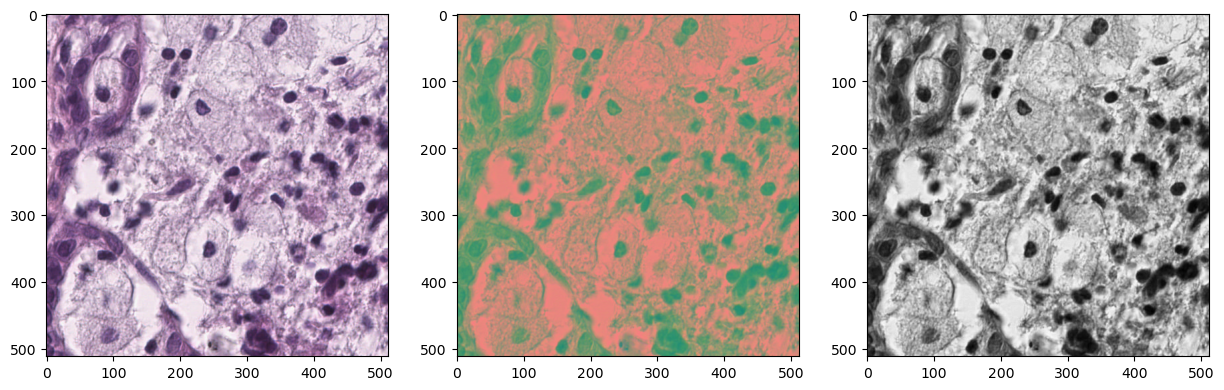

In [7]:
test_img = cv2.imread(test_img_path, cv2.IMREAD_UNCHANGED)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGRA2RGB)
cielab_test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2LAB)
bw_test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(1, 3, figsize=(15, 15))


print(f"RGB image shape: {test_img.shape}")
print(f"RGB example pixel values: {test_img[200, 100, :]}")

print(f"CIELAB image shape: {cielab_test_img.shape}")
print(f"CIELAB example pixel values:{cielab_test_img[200, 100, :]}")

print(f"Black and white image shape: {bw_test_img.shape}")
print(f"Black and white example pixel values: {bw_test_img[200, 100]}")

ax[0].imshow(test_img)
ax[1].imshow(cielab_test_img)
ax[2].imshow(bw_test_img, cmap="gray")
plt.show()

In [8]:
def cielab_intensify_to_rgb(img: Union[np.ndarray, torch.Tensor], rate: float):
    cie_img = np.array(img)
    if isinstance(img, torch.Tensor):
        cie_img = cie_img * 255
    cie_img[:, :, 0][cie_img[:, :, 0] > 127] = np.clip(cie_img[:, :, 0][cie_img[:, :, 0] > 127] * (1 + rate), 0, 255)
    cie_img[:, :, 0][cie_img[:, :, 0] < 127] = np.clip(cie_img[:, :, 0][cie_img[:, :, 0] < 127] * (1 - rate), 0, 255)

    cie_img[:, :, 1][cie_img[:, :, 1] > 127] = np.clip(cie_img[:, :, 1][cie_img[:, :, 1] > 127] * (1 - rate), 0, 255)
    cie_img[:, :, 1][cie_img[:, :, 1] < 127] = np.clip(cie_img[:, :, 1][cie_img[:, :, 1] < 127] * (1 + rate), 0, 255)

    cie_img[:, :, 2][cie_img[:, :, 2] > 127] = np.clip(cie_img[:, :, 2][cie_img[:, :, 2] > 127] * (1 - rate), 0, 255)
    cie_img[:, :, 2][cie_img[:, :, 2] < 127] = np.clip(cie_img[:, :, 2][cie_img[:, :, 2] < 127] * (1 + rate), 0, 255)
    
    cie_img = cie_img.astype(np.uint8)
    rgb_img = cv2.cvtColor(cie_img, cv2.COLOR_LAB2RGB)
    return rgb_img

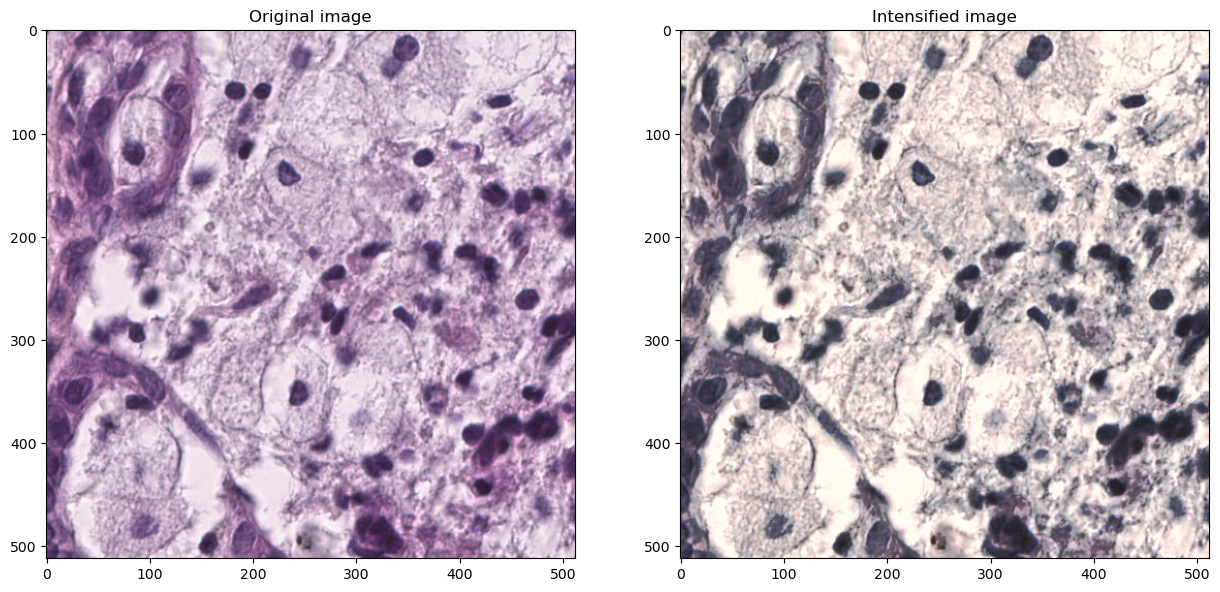

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(test_img)
ax[0].set_title("Original image")
ax[1].imshow(cielab_intensify_to_rgb(cielab_test_img, 0.1))
ax[1].set_title("Intensified image")
plt.show()

### Augmentation for training and validation

In [10]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate([90, 90], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

### Class label creation

| Class | Label |
| --- | --- |
| 0 | Type_N |
| 1 | Type_PB |
| 2 | Type_UDH |
| 3 | Type_FEA |
| 4 | Type_ADH |
| 5 | Type_DCIS |
| 6 | Type_IC |

In [11]:
train_20x_patches_paths = sorted(glob.glob(PATCH_PATH + "/train/**/*-20x"))

set(map(lambda x: "-".join(os.path.split(x)[-1].split("-")[:-2]), train_20x_patches_paths))

{'ADH',
 'ADH-sure',
 'BENIGN',
 'Benign sure',
 'Benign-sure',
 'DCIS',
 'DCIS-sure',
 'FEA',
 'FEA-sure',
 'MALIGNANT',
 'Malignant',
 'Malignant-sure',
 'Pathologica benign',
 'Pathological-benign',
 'Pathological-benign (Benign-sure)',
 'UDH',
 'UDH-sure'}

In [12]:
name_to_class_mapping = {
    "BENIGN": 1, # unable to cross reference with the roi dataset from BRACS
    "Benign sure": 1,
    "Benign-sure": 1,
    "Pathological-benign (Benign-sure)": 1, # unable to cross reference with the roi dataset from BRACS
    "Pathologica benign": 2,
    "Pathological-benign": 2,
    "UDH": 3,
    "UDH-sure": 3,
    "FEA": 4,
    "FEA-sure": 4,
    "ADH": 5,
    "ADH-sure": 5,
    "DCIS": 6,
    "DCIS-sure": 6,
    "MALIGNANT": 7,
    "Malignant": 7,
    "Malignant-sure": 7
}

class_to_type_mapping = {
    1: "Type_N",
    2: "Type_PB",
    3: "Type_UDH",
    4: "Type_FEA",
    5: "Type_ADH",
    6: "Type_DCIS",
    7: "Type_IC"
}

### Sample Dataset and Data Loader definition

In [13]:
class PatchDataset(Dataset):
    def __init__(self, imgPaths, maskPaths, mode: str, transform=None, seed=0):
        self.imgs = imgPaths
        self.masks = maskPaths
        self.transform = transform
        self.mode = mode
        self.seed = seed
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # print(f"image path: {img_path}, mask path: {mask_path}")
        
        if self.mode == "RGB":
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        elif self.mode == "CIELAB":
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif self.mode == "BW":
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        class_id = name_to_class_mapping["-".join(img_path.split("/")[-3].split("-")[:-2])]

        # set seed so that the same transformation is applied to image and mask
        if self.transform:
            # transform the image
            random.seed(self.seed)
            transformed = self.transform(image=img, mask=mask)
            img, mask = transformed["image"].float()/255.0, transformed["mask"]/255.0
            mask[mask > 0.5] = class_id
            mask[mask <= 0.5] = 0
            mask = mask.long()
            self.seed += 1
            
        return img, mask

In [14]:
train_20x_img_path = []
train_20x_mask_path = []

for roi in train_20x_patches_paths:
    train_20x_img_path.extend(glob.glob(roi + "/patch/*.png"))
    train_20x_mask_path.extend(glob.glob(roi + "/mask/*.png"))

train_20x_img_path.sort()
train_20x_mask_path.sort()

assert len(train_20x_img_path) == len(train_20x_mask_path), "Number of images and masks should be equal"

print("Number of 20x train images", len(train_20x_img_path))

Number of 20x train images 12056


In [15]:
val_20x_patches_paths = sorted(glob.glob(PATCH_PATH + "/val/**/*-20x"))

val_20x_img_path = []
val_20x_mask_path = []

for roi in val_20x_patches_paths:
    val_20x_img_path.extend(glob.glob(roi + "/patch/*.png"))
    val_20x_mask_path.extend(glob.glob(roi + "/mask/*.png"))

val_20x_img_path.sort()
val_20x_mask_path.sort()

assert len(val_20x_img_path) == len(val_20x_mask_path), "Number of images and masks should be equal"

print("Number of 20x val images", len(val_20x_img_path))

Number of 20x val images 1072


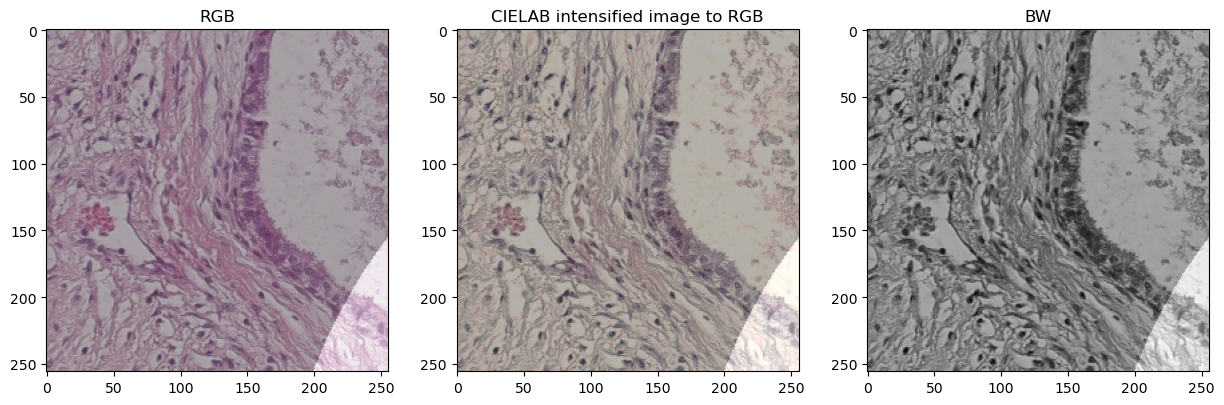

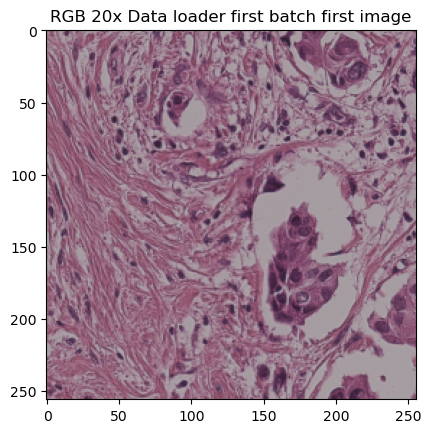

In [16]:
patch_rgb_20x_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="RGB",
    transform=train_transform,
    seed=0
)

patch_cielab_20x_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="CIELAB",
    transform=train_transform,
    seed=0
)

patch_bw_20x_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="BW",
    transform=train_transform,
    seed=0
)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].title.set_text("RGB")
rgb_img, rgb_mask = patch_rgb_20x_dataset[0]
ax[0].imshow(rgb_img.permute(1, 2, 0))
ax[0].imshow(rgb_mask > 0, alpha=0.3, cmap="gray")

ax[1].title.set_text("CIELAB intensified image to RGB")
cielab_img, cielab_mask = patch_cielab_20x_dataset[0]
ax[1].imshow(cielab_intensify_to_rgb(cielab_img.permute(1, 2, 0), 0.1))
ax[1].imshow(cielab_mask > 0, alpha=0.3, cmap="gray")

ax[2].title.set_text("BW")
bw_img, bw_mask = patch_bw_20x_dataset[0]
ax[2].imshow(bw_img.permute(1, 2, 0), cmap="gray")
ax[2].imshow(bw_mask > 0, alpha=0.3, cmap="gray")

plt.show()

rgb_20x_loader = DataLoader(patch_rgb_20x_dataset, batch_size=8, shuffle=True)
cielab_20x_loader = DataLoader(patch_cielab_20x_dataset, batch_size=8, shuffle=True)
bw_20x_loader = DataLoader(patch_bw_20x_dataset, batch_size=8, shuffle=True)

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
img, mask = next(iter(rgb_20x_loader))

plt.title("RGB 20x Data loader first batch first image")
plt.imshow(img[0].permute(1, 2, 0))
plt.imshow(mask[0] > 0, alpha=0.3, cmap="gray")
plt.show()

### Convolution block
A double convolutional block that is used both in upsampling and downsampling blocks

In [17]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same"):
        super(Conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

### Downsample block
A downsampling block that wraps the convolution block and max pooling layer

In [18]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same"):
        super(Downsample_block, self).__init__()
        self.conv_block = Conv_block(in_channels, out_channels, kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=0.3)

    def forward(self, x):
        skip = self.conv_block(x)
        x = self.pool(skip)
        x = self.dropout(x)
        return x, skip

### Upsample block
A upsampling block that wraps the concatenates the skip connection features and wraps the transpose convolution layer and convolution block

In [19]:
class Upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same"):
        super(Upsample_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=0.3)
        self.conv_block = Conv_block(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], axis=1)
        x = self.dropout(x)
        x = self.conv_block(x)
        return x

### UNet Model
Combine all parts for the model

In [20]:
class UNet(nn.Module):
    def __init__(self, out_channels=2, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        # Downsample 64 -> 128 -> 256 -> 512
        self.down1 = Downsample_block(3, features[0])
        self.down2 = Downsample_block(features[0], features[1])
        self.down3 = Downsample_block(features[1], features[2])
        self.down4 = Downsample_block(features[2], features[3])
        # Bottleneck 512 -> 1024
        self.bottleneck = Conv_block(features[3], features[3]*2, kernel_size=3, stride=1, padding="same")
        # Upsample 512 -> 256 -> 128 -> 64
        self.up1 = Upsample_block(features[3]*2, features[3])
        self.up2 = Upsample_block(features[3], features[2])
        self.up3 = Upsample_block(features[2], features[1])
        self.up4 = Upsample_block(features[1], features[0])
        self.out = nn.Conv2d(features[0], out_channels, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        # Downsample 64 -> 128 -> 256 -> 512
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        # Bottleneck 512 -> 1024
        x = self.bottleneck(x)
        # Upsample 512 -> 256 -> 128 -> 64 with concatenation and skip connections
        x = self.up1(x, skip4)
        x = self.up2(x, skip3)
        x = self.up3(x, skip2)
        x = self.up4(x, skip1)
        x = self.out(x)
        return x

### Model compile and Training

Example for model compilation

In [21]:
model = torch.compile(UNet(out_channels=8).to(device))

Define training loop

In [22]:
def run_train_loop(
        model: UNet, num_classes:int,
        train_batches: DataLoader, valid_batches: DataLoader, train_set_len: int, val_set_len: int,
        epochs: int, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,
        set_name: str
    ):
    model.to(device)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_dice": [],
        "val_dice": []
    }

    for epoch in range(epochs):
        # set the model in training phase
        model.train()

        total_train_loss = 0
        total_val_loss = 0
        train_dice = 0
        val_dice = 0

        for data, targets in tqdm(train_batches):
            data = data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            output = model(data)
            loss = criterion(output, targets)

            # backward
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            total_train_loss += loss.detach()*data.size(0)

            # evaluate dice coefficient on test set
            tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(output, dim=1).long(), targets, mode="multiclass", num_classes=num_classes)
            train_dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")

        # set the model in evaluation phase
        with torch.no_grad():
            model.eval()

            for data, targets in valid_batches:
                data = data.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                # forward
                output = model(data)
                loss = criterion(output, targets)

                total_val_loss += loss.detach()*data.size(0)
                
                # evaluate dice coefficient on test set
                tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(output, dim=1).long(), targets, mode="multiclass", num_classes=num_classes)
                val_dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")

        # compute the average loss and accuracy
        avg_train_loss = total_train_loss.cpu() / train_set_len
        avg_val_loss = total_val_loss.cpu() / val_set_len
        
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_dice"].append(train_dice)
        history["val_dice"].append(val_dice)

        if (epoch+1) % 20 == 0:
            torch.save(
                {
                    "epoch": epoch+1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "history": history,
                },
                f"{set_name}_model_epoch{epoch+1}.pth"
            )

        # print the loss and accuracy for the epoch
        print(f"Epoch {(epoch+1)}/{epochs} Train Loss: {avg_train_loss:.4f} Validation Loss: {avg_val_loss:.4f}, Train Dice Score: {train_dice:.4f} Validation Dice Score: {val_dice:.4f}")

    return history

In [23]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="validation loss")
    plt.title("Loss vs epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_dice"], label="train dice score")
    plt.plot(history["val_dice"], label="validation dice score")
    plt.title("Dice score vs epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Weighted Dice Coefficient")
    plt.legend()
    plt.show()

Create seed worker for data loader

In [24]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)
    torch.cuda.manual_seed_all(worker_seed)

<i>Optional garbage collection to free up space</i>

In [25]:
torch.cuda.empty_cache()
gc.collect()

6409

#### Sample training
learning rate: 1e-4, batch size: 32

In [29]:
# recompile model
model = UNet(out_channels=8)

# define the hyperparameters
LEARNING_RATE = 1e-4
BATCHSIZE = 16
EPOCHS = 50
NUM_WORKERS = 2

patch_rgb_20x_train_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="RGB",
    transform=train_transform,
    seed=0
)

patch_rgb_20x_val_dataset = PatchDataset(
    imgPaths=val_20x_img_path,
    maskPaths=val_20x_mask_path,
    mode="RGB",
    transform=val_transform,
    seed=0
)

if __name__ == "__main__":

    worker_g = torch.Generator()
    worker_g.manual_seed(0)
    train_batches = DataLoader(
        patch_rgb_20x_train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=2
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        patch_rgb_20x_val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=2
    )
    
    # define the loss function and the optimizer
    criterion = smp.losses.DiceLoss(mode="multiclass", from_logits=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    start_time = time.time()

    # train the network
    history = run_train_loop(model, 8, train_batches, valid_batches, len(patch_rgb_20x_train_dataset), len(patch_rgb_20x_val_dataset), EPOCHS, criterion, optimizer, "unetset1")
    torch.save(
        {
            "epoch": 100,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
        },
        f"unetset1_model_final.pth"
    )

    # display the total time needed to perform the training
    end_time = time.time()
    print(f"Total time taken to train the model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history)

100%|██████████| 754/754 [1:41:19<00:00,  8.06s/it]


Epoch 1/50 Train Loss: 0.6414 Validation Loss: 0.2586, Train Dice Score: 0.0013 Validation Dice Score: 0.0698


100%|██████████| 754/754 [1:49:37<00:00,  8.72s/it]


Epoch 2/50 Train Loss: 0.5985 Validation Loss: 0.2532, Train Dice Score: 0.1802 Validation Dice Score: 0.0695


100%|██████████| 754/754 [1:43:53<00:00,  8.27s/it]


Epoch 3/50 Train Loss: 0.5773 Validation Loss: 0.2518, Train Dice Score: 0.1121 Validation Dice Score: 0.0237


100%|██████████| 754/754 [1:38:16<00:00,  7.82s/it]


Epoch 4/50 Train Loss: 0.5640 Validation Loss: 0.2599, Train Dice Score: 0.1485 Validation Dice Score: 0.0075


100%|██████████| 754/754 [1:38:14<00:00,  7.82s/it]


Epoch 5/50 Train Loss: 0.5607 Validation Loss: 0.2525, Train Dice Score: 0.1855 Validation Dice Score: 0.1223


100%|██████████| 754/754 [1:38:19<00:00,  7.82s/it]


Epoch 6/50 Train Loss: 0.5445 Validation Loss: 0.2565, Train Dice Score: 0.1407 Validation Dice Score: 0.0624


100%|██████████| 754/754 [1:38:15<00:00,  7.82s/it]


Epoch 7/50 Train Loss: 0.5370 Validation Loss: 0.2462, Train Dice Score: 0.0068 Validation Dice Score: 0.0961


100%|██████████| 754/754 [1:38:23<00:00,  7.83s/it]


Epoch 8/50 Train Loss: 0.5399 Validation Loss: 0.2525, Train Dice Score: 0.1481 Validation Dice Score: 0.0758


100%|██████████| 754/754 [1:42:52<00:00,  8.19s/it]


Epoch 9/50 Train Loss: 0.5286 Validation Loss: 0.2512, Train Dice Score: 0.1676 Validation Dice Score: 0.0697


 18%|█▊        | 135/754 [19:09<1:27:49,  8.51s/it]


KeyboardInterrupt: 

<i>Optional garbage collection to free up space</i>

In [28]:
torch.cuda.empty_cache()
gc.collect()

3908